# **Proyecto 2 - MDS7202 Laboratorio de Programación Científica para Ciencia de Datos 📚**

**MDS7202: Laboratorio de Programación Científica para Ciencia de Datos**

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Equipo:

- Mathias González Espinoza 
- Eduardo Javier Silva Gaete

### **Link de repositorio de GitHub:** [https://github.com/Zerzer0/MDS7202](https://github.com/Zerzer0/MDS7202)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import shap

from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_object_dtype

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import RandomOverSampler
# from pycaret.classification import *

import optuna
from optuna.samplers import TPESampler
from optuna.integration import XGBoostPruningCallback
from imblearn.under_sampling import RandomUnderSampler

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Informe

## 1. Introducción

En el presente informe se desarrolla un modelo de riesgo crediticio para predecir la probabilidad de incumplimiento de pago de los clientes de nuestra contraparte Giturra, con el objetivo de evaluar el riesgo asociado a cada solicitud de préstamo y mejorar la calidad de las decisiones crediticias. Los datos que utilizamos para trabajar nuestro modelo poseen una amplia gama de variables de los usuarios, como ocupación, historiales de crédito, ingresos, número de cuentas vancarias, entre otros factores financieros relevantes, los cuales nos serviran para poder entrenar un modelo más robusto y util para las predicciones.

Puesto que abordamos un problema en la que nuestra variable objetivo presenta un desbalance de clases, además que en nuestro contexto es importante tomar en cuenta los costos asociados a los falsos positivos (clasificar erróneamente un cliente como de alto riesgo cuando no lo es) y los falsos negativos (no detectar un cliente de alto riesgo que luego incumple), la métrica que mejor sirve para evaluar el desempeño del modelo es `F1-Score`, ya que entrega un equilibrio adecuado entre la precisión (capacidad de identificar correctamente a los incumplidores) y el recall (capacidad de no pasar por alto a los incumplidores).


El modelo que finalmente se utilizó para resolver la problematica fue "xgboost", un modelo que se basa en arboles de decisión y refuerzo de gradientes. Además se eliminaron valores nulos y otros valores extraños del dataset. Por otro lado se aplicaron transformaciones a las columnas, se aplicó "OnehotEncoder" y "StandarScaler" para las columnas categoricas y numericas respectivamente. Además se balancearon las clases debido a la baja cantidad de "labels" igual a 1.

Finalmente se obtuvo un f1_score del 60,84% con el mejor modelo obtenido. Estos resultados son bastante bajos, por lo cual el modelo es bastante ineficiente a la hora de predecir el riesgo de un cliente, incluso luego de balancear las clases en la data de entrenamiento. Un buena forma de mejorar este modelo sería aplicando "Prunning" a la optimización de parametros, lo cual podria aumentar el F1_score.


## 2. Análisis exploratorio de datos

In [2]:
df = pd.read_parquet('dataset.pq')
df

,customer_id,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,...,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score
0,CUS_0xd40,23.0,Scientist,19114.12,1824.843333,3,4,3,4.0,3,...,4.0,809.98,23.933795,NaN,No,49.574949,24.785217,High_spent_Medium_value_payments,358.124168,0
1,CUS_0x21b1,28.0,Teacher,34847.84,3037.986667,2,4,6,1.0,3,...,2.0,605.03,32.933856,27.0,No,18.816215,218.904344,Low_spent_Small_value_payments,356.078109,0
2,CUS_0x2dbc,34.0,Engineer,143162.64,12187.220000,1,5,8,3.0,8,...,3.0,1303.01,38.374753,18.0,No,246.992319,10000.000000,High_spent_Small_value_payments,895.494583,0
3,CUS_0xb891,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,-100.0,4,...,4.0,632.46,27.332515,17.0,No,16.415452,125.617251,High_spent_Small_value_payments,379.216381,0
4,CUS_0x1cdb,21.0,Developer,35547.71,2853.309167,7,5,5,-100.0,1,...,4.0,943.86,25.862922,31.0,Yes,0.000000,181.330901,High_spent_Small_value_payments,364.000016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,CUS_0x372c,19.0,Lawyer,42903.79,3468.315833,0,4,6,1.0,9,...,1.0,1079.48,35.716618,28.0,No,34.975457,115.184984,High_spent_Medium_value_payments,NaN,0
12496,CUS_0xf16,45.0,Media_Manager,16680.35,NaN,1,1,5,4.0,1,...,8.0,897.16,41.212367,NaN,No,41.113561,70.805550,Low_spent_Large_value_payments,NaN,0
12497,CUS_0xaf61,50.0,Writer,37188.10,3097.008333,1,4,5,3.0,7,...,3.0,620.64,39.300980,30.0,No,84.205949,42.935566,High_spent_Medium_value_payments,NaN,0
12498,CUS_0x8600,29.0,Architect,20002.88,1929.906667,10,8,29,5.0,33,...,9.0,3571.70,37.140784,6.0,Yes,60.964772,34.662906,High_spent_Large_value_payments,NaN,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               12500 non-null  object 
 1   age                       12500 non-null  float64
 2   occupation                12500 non-null  object 
 3   annual_income             12500 non-null  float64
 4   monthly_inhand_salary     10584 non-null  float64
 5   num_bank_accounts         12500 non-null  int64  
 6   num_credit_card           12500 non-null  int64  
 7   interest_rate             12500 non-null  int64  
 8   num_of_loan               12500 non-null  float64
 9   delay_from_due_date       12500 non-null  int64  
 10  num_of_delayed_payment    11660 non-null  float64
 11  changed_credit_limit      12246 non-null  float64
 12  num_credit_inquiries      12243 non-null  float64
 13  outstanding_debt          12500 non-null  float64
 14  credit

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,12500.0,1.057718e+02,6.645027e+02,-5.000000e+02,25.000000,33.000000,42.000000,8.678000e+03
annual_income,12500.0,1.616206e+05,1.297842e+06,7.005930e+03,19453.327500,37572.375000,72690.215000,2.383470e+07
monthly_inhand_salary,10584.0,4.186635e+03,3.173690e+03,3.036454e+02,1622.408646,3087.595000,5967.937500,1.520463e+04
num_bank_accounts,12500.0,1.693992e+01,1.143508e+02,-1.000000e+00,3.000000,6.000000,7.000000,1.756000e+03
num_credit_card,12500.0,2.317272e+01,1.320059e+02,0.000000e+00,4.000000,5.000000,7.000000,1.499000e+03
interest_rate,12500.0,7.321336e+01,4.686822e+02,1.000000e+00,8.000000,14.000000,20.000000,5.789000e+03
num_of_loan,12500.0,3.099440e+00,6.510528e+01,-1.000000e+02,1.000000,3.000000,5.000000,1.495000e+03
delay_from_due_date,12500.0,2.106088e+01,1.486309e+01,-5.000000e+00,10.000000,18.000000,28.000000,6.700000e+01
num_of_delayed_payment,11660.0,3.293542e+01,2.374377e+02,-3.000000e+00,9.000000,14.000000,18.000000,4.293000e+03
changed_credit_limit,12246.0,1.039858e+01,6.799253e+00,-6.490000e+00,5.370000,9.410000,14.940000,3.697000e+01


In [5]:
df.describe(exclude=np.number).T

,count,unique,top,freq
customer_id,12500,12500,CUS_0xd40,1
occupation,12500,16,_______,880
payment_of_min_amount,12500,3,Yes,6571
payment_behaviour,12500,7,Low_spent_Small_value_payments,3202


In [6]:
for col in df.columns:
    print(f"Valores únicos de columna '{col}':")
    print(f"{df[col].unique()}\n")

Valores únicos de columna 'customer_id':
['CUS_0xd40' 'CUS_0x21b1' 'CUS_0x2dbc' ... 'CUS_0xaf61' 'CUS_0x8600'
 'CUS_0x942c']

Valores únicos de columna 'age':
[  23.   28.   34.   55.   21.   31.   30.   24.   45.   41.   33.   36.
   39.   37.   20.   46.   26.   32.   42.   48.   40.   38.   44.   22.
   16.   19.   27.   43. 3052.   14.   25.   18. 4431.   47.   35.   17.
   53.   56.   54.   29.   15.   49. 3115.   51.   50. -500.   52. 4670.
  395. 4049. 4710. 4351. 5784. 5645. 3513. 7805.  831. 8105. 2823.  886.
 3553. 7068. 5504. 4820. 5194. 6556. 1203. 8043. 8628. 3791. 8216.  236.
 5195. 3986. 7123. 5498. 7060. 8421. 7456. 7353. 4021.  306. 1066. 4391.
 2997. 3834. 3493. 6744. 7715. 7723. 4630. 5714. 3038. 4897. 6408. 5981.
 6646. 8669. 6767.  169. 1248. 6360. 5018.  203. 2778. 7490. 1418. 4679.
 5751. 2546. 6611.  325.  305. 8623. 1265. 1094. 2672. 8663. 1520. 4056.
 7279. 5340.  813. 5177.  506. 4177. 2048. 6378. 5376. 3899. 5959. 2347.
 2593. 4120.  655. 4746. 6909. 6506.  

In [7]:
df.isnull().sum()

customer_id                    0
age                            0
occupation                     0
annual_income                  0
monthly_inhand_salary       1916
num_bank_accounts              0
num_credit_card                0
interest_rate                  0
num_of_loan                    0
delay_from_due_date            0
num_of_delayed_payment       840
changed_credit_limit         254
num_credit_inquiries         257
outstanding_debt               0
credit_utilization_ratio       0
credit_history_age          1120
payment_of_min_amount          0
total_emi_per_month            0
amount_invested_monthly      586
payment_behaviour              0
monthly_balance              355
credit_score                   0
dtype: int64

In [8]:
df.duplicated().sum()

0

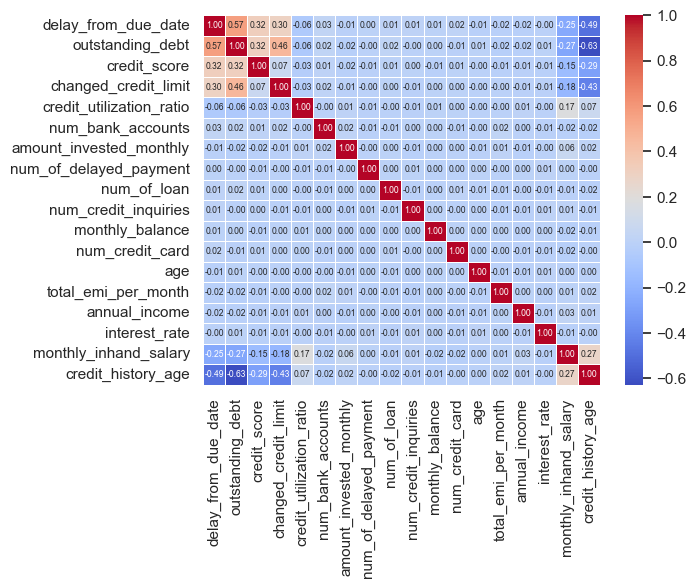

In [9]:
correlation_matrix = df.drop(columns=['customer_id', 'occupation', 'payment_of_min_amount', 'payment_behaviour']).corr()

order = correlation_matrix.mean().sort_values(ascending=False).index
correlation_matrix = correlation_matrix.loc[order, order]

sns.set(style="white")  
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, annot_kws={"size": 6.14})

plt.show()

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'annual_income'}>,
        <Axes: title={'center': 'monthly_inhand_salary'}>,
        <Axes: title={'center': 'num_bank_accounts'}>],
       [<Axes: title={'center': 'num_credit_card'}>,
        <Axes: title={'center': 'interest_rate'}>,
        <Axes: title={'center': 'num_of_loan'}>,
        <Axes: title={'center': 'delay_from_due_date'}>],
       [<Axes: title={'center': 'num_of_delayed_payment'}>,
        <Axes: title={'center': 'changed_credit_limit'}>,
        <Axes: title={'center': 'num_credit_inquiries'}>,
        <Axes: title={'center': 'outstanding_debt'}>],
       [<Axes: title={'center': 'credit_utilization_ratio'}>,
        <Axes: title={'center': 'credit_history_age'}>,
        <Axes: title={'center': 'total_emi_per_month'}>,
        <Axes: title={'center': 'amount_invested_monthly'}>],
       [<Axes: title={'center': 'monthly_balance'}>,
        <Axes: title={'center': 'credit_score'}>, <Axes: >, <

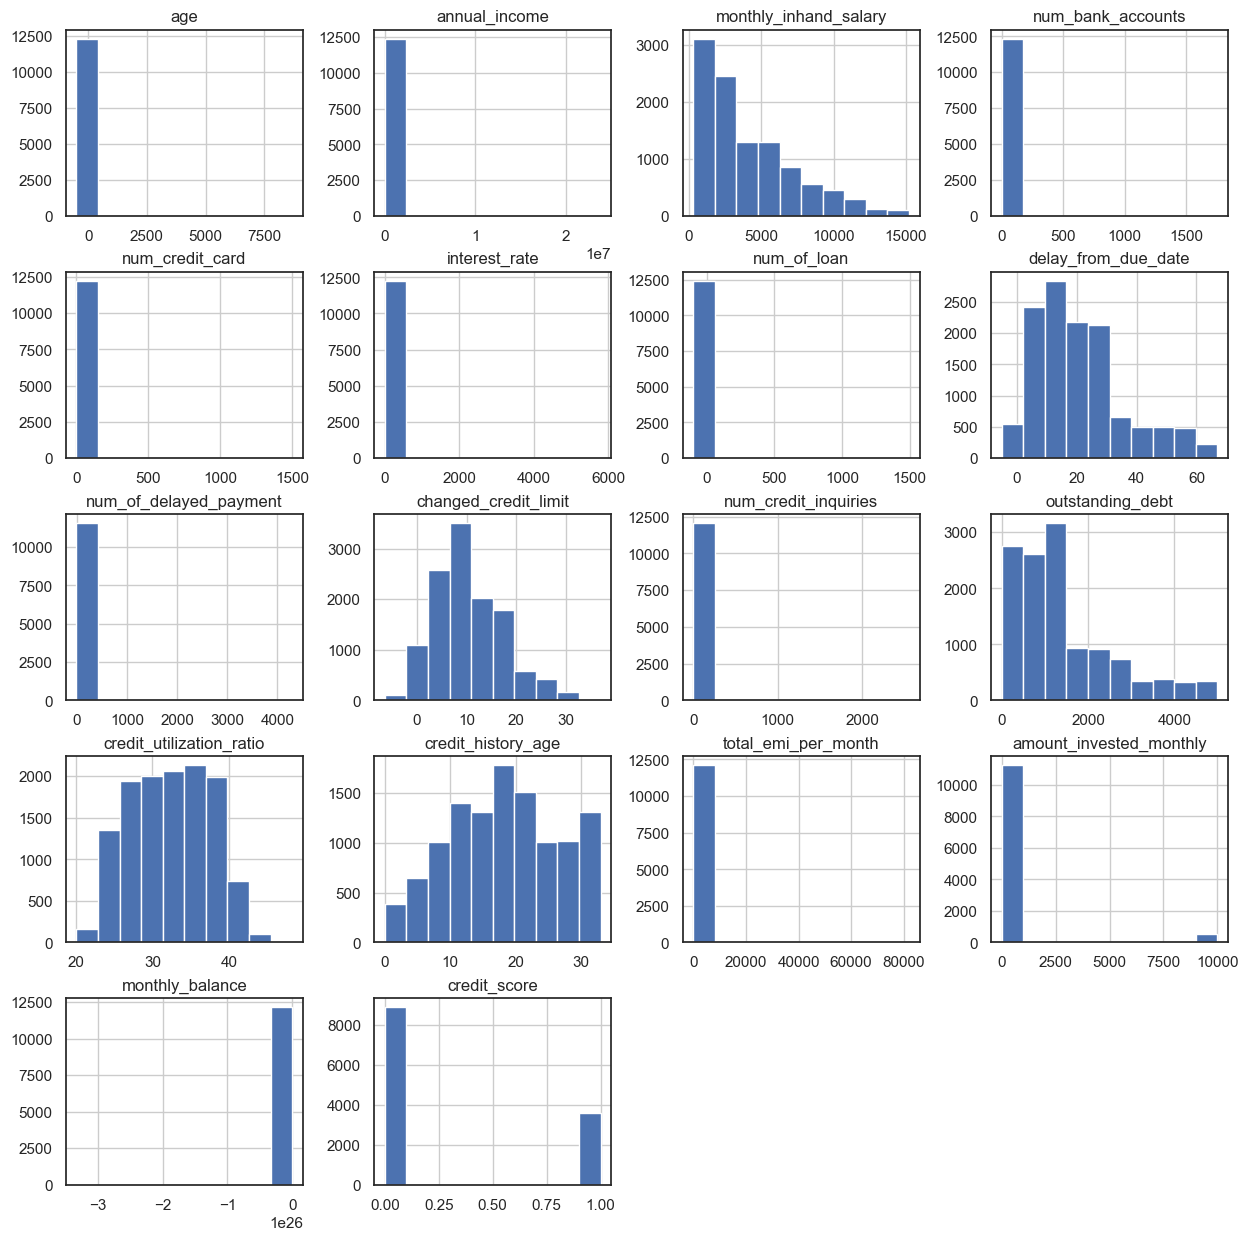

In [10]:
df.hist(figsize=(15,15))

Cosas a destacar:

1. En **'occupation'** hay un nombre '_______'.
2. En **'age'**, **'num_bank_accounts'**, **'num_of_loan'**, **'delay_from_due_date'**, **'num_of_delayed_payment'**, y **'changed_credit_limit'**  hay valores negativos (**'monthly_balance'** el negativo puede tomarse como que queda debiendo dinero).
3. En **'payment_behaviour'** se encuentra un valor extraño ('!@9#%8').
4. Varios valores nulos.
5. Clase objetivo **'credit_score'** desbalanceada.

## 3. Preparación de datos

Para la preparación de los datos, primero se corregirá los valores extraños que se encontraron durante el análisis exploratorio de datos, transformando estos valores a **nulos**:

In [11]:
df['occupation'].replace('_______', np.nan, inplace=True)
df['payment_behaviour'].replace('!@9#%8', np.nan, inplace=True)

columnas_a_modificar = ["age", "num_bank_accounts", "num_of_loan", "delay_from_due_date", "num_of_delayed_payment", "changed_credit_limit"]
for i in columnas_a_modificar:
    df[i] = df[i].map(lambda x: np.nan if x < 0 else x)

Ahora designamos nuestras variables con valores categóricos y numéricos, eliminando en el paso las variables que no aportan en la predicción, y sacando de la lista nuestra variable objetivo:

In [12]:
df_new = df.drop(columns='customer_id')

columnas_categoricas = df_new.drop(columns=['credit_score']).select_dtypes(include='object').columns
columnas_numericas = df_new.drop(columns=['credit_score']).select_dtypes(exclude='object').columns

Tambien generaremos un `ColumnTransformer` que nos ayudará a trabajar los datos para que puedan ser ingresados a los algoritmos de predición, entre los procesamiento que haremos están:

- **Variables categóricas:** Se tranformarán los datos categóricos a variable one hot, usando `OneHotEncoder`, con el parámetro `sparse_output=False` para poder tener posteriormente una salida de los datos en formato pandas.
- **Variables numéricas:** Se realizará una estandarización de los datos usando `StandardScaler` con parametros estándar.

Además, designamos `.set_output(transform="pandas")` para que la salida de los datos procesados esté en formato pandas. Finalmente realizamos la transformación de los datos.

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('StandarScaler', StandardScaler(), columnas_numericas),
        ('OneHotEncoder', OneHotEncoder(sparse_output=False), columnas_categoricas)
    ])
preprocessor.set_output(transform="pandas")

#preprocessor.fit_transform(df_new)

ColumnTransformer(transformers=[('StandarScaler', StandardScaler(),
                                 Index(['age', 'annual_income', 'monthly_inhand_salary', 'num_bank_accounts',
       'num_credit_card', 'interest_rate', 'num_of_loan',
       'delay_from_due_date', 'num_of_delayed_payment', 'changed_credit_limit',
       'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio',
       'credit_history_age', 'total_emi_per_month', 'amount_invested_monthly',
       'monthly_balance'],
      dtype='object')),
                                ('OneHotEncoder',
                                 OneHotEncoder(sparse_output=False),
                                 Index(['occupation', 'payment_of_min_amount', 'payment_behaviour'], dtype='object'))])

Se puede ver que a todas las variables categóricas se le realizó el encoder OneHot, y a las variables numéricas se les estandarizó.

Lo siguiente que se realizará es separar nuestros datos en conjuntos de entrenamiento, prueba y validación usando `train_test_split`, con proporciones 90%, 10% y 10% respectivamente, además de fijar una semilla para poder replicar resultados, y de balancear las clases usando `stratify`.

In [14]:
seed = 42

X = df_new.drop(columns='credit_score')
y = df_new['credit_score']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=seed, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=seed, stratify=y_temp)

print(f"Número de datos en set de entrenamiento: {X_train.shape[0]}")
print(f"Número de datos en set de validación: {X_val.shape[0]}")
print(f"Número de datos en set de prueba: {X_test.shape[0]}")

Número de datos en set de entrenamiento: 10000
Número de datos en set de validación: 1250
Número de datos en set de prueba: 1250


Para el caso de los valores nulos, nos enfocaremos en primera instancia en la eliminación de los valores nulos, para ellos se crea una función que permite elegir entre inputar datos o eliminarlos, para luego ser guardado en un `FunctionTransformer`.

In [15]:
def clean_nan(dataframe, variables=None, tecnica='dropna'):
            df = dataframe.copy()
            # Filtración de variables
            if variables == None:
                variables = df.columns
            else:
                variables = list(variables)

            df = df[variables]

            if tecnica == "dropna":
                df.dropna(subset=variables, inplace=True)
            elif tecnica == "imputer":
                for var in variables:
                    data = df[var]
                    var_type = data.dtype
                    if is_numeric_dtype(var_type):
                        imputer = SimpleImputer(strategy="mean")
                        df[var] = imputer.fit_transform(df[var])
                    elif is_object_dtype(var_type):
                        imputer = SimpleImputer(strategy="most_frequent")
                        df[var] = SimpleImputer.fit_transform(df[var])
            else:
                raise ValueError("Técnica inválida")
            
            return df

tranformer_dropna = FunctionTransformer(clean_nan)

Aplicando el `FunctionTransformer` a nuestro dataframe, obtendremos la siguiente cantidad de datos en los set de entrenamiento, validación y prueba.

In [16]:
seed = 42

df_dopna = tranformer_dropna.fit_transform(df_new)

X = df_dopna.drop(columns='credit_score')
y = df_dopna['credit_score']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=seed, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=seed, stratify=y_temp)

print(f"Número de datos en set de entrenamiento: {X_train.shape[0]}")
print(f"Número de datos en set de validación: {X_val.shape[0]}")
print(f"Número de datos en set de prueba: {X_test.shape[0]}")

Número de datos en set de entrenamiento: 5099
Número de datos en set de validación: 638
Número de datos en set de prueba: 638


## 4. Baseline

En esta sección se implementarán varias `Pipeline` usando el `ColumnTransformer` implementado anteriormente. En cada Pipeline, variaremos el modelo a entrenar, y cabe decir que cada modelo usado se instanciará con sus parámetros por defecto, puesto que solo queremos comprar los modelos bases en primera instancia. Para el entrenamiento de cada modelo se usará el set de entrenamiento, y para evaluar, el set de prueba. Tambien se fija semilla para poder replicar los resultados. 

Luego de ya entrenados los modelos, se prodecerá a entregar resultados de todas las métrica usando `classification_report`, pero la métrica en la que no centraremos principalmente, tal como se dijo en la introducción, será `F1-Score`, donde guardaremos su valor con su correspondiente modelo en un `Dataframe` y compararemos todos los modelos para entregar conclusiones de cual obtuvo mejor desempeño.

In [33]:
# Lista con los modelos
models = [
    ('Dummy', DummyClassifier(strategy='stratified', random_state=seed)),
    ('LogisticRegression', LogisticRegression(random_state=seed)),
    ('KNeighborsClassifier', KNeighborsClassifier()),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=seed)),
    ('SVC', SVC(random_state=seed)),
    ('RandomForestClassifier', RandomForestClassifier(random_state=seed)),
    ('LGBMClassifier', LGBMClassifier(random_state=seed)),
    ('XGBClassifier', XGBClassifier(random_state=seed)),
    #('XGBRegressor',XGBRegressor(random_state=seed))
]

# Lista donde se guardarán los diccionarios con los valores de las métricas por modelo
results = []

rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')
X_resampled, y_X_resampled = rus.fit_resample(X_train, y_train)

for name, model in models:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('clasificador', model)
    ])

    # Entrenar el modelo, evaluar y entregar métricas
    pipeline.fit(X_resampled, y_X_resampled)
    y_pred = pipeline.predict(X_test)
    reporte_clasificacion = classification_report(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Mostramos los resultados
    print(f'Classification Report para {name}:\n{reporte_clasificacion}')
    print(f'F1-Score para {name}: {f1}\n')

    # Guardamos los resultados en un diccionario y los agregamos a la lista de resultados
    results.append({'Modelo': name, 'F1-Score': f1})

Classification Report para Dummy:
              precision    recall  f1-score   support

           0       0.71      0.51      0.59       453
           1       0.29      0.48      0.36       185

    accuracy                           0.50       638
   macro avg       0.50      0.50      0.48       638
weighted avg       0.58      0.50      0.52       638

F1-Score para Dummy: 0.35887096774193555

Classification Report para LogisticRegression:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       453
           1       0.49      0.63      0.55       185

    accuracy                           0.70       638
   macro avg       0.66      0.68      0.67       638
weighted avg       0.73      0.70      0.71       638

F1-Score para LogisticRegression: 0.5510688836104514

Classification Report para KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.82      0.68      0.75       453
           

In [34]:
# Convertimos el diccionario con los resultados en un DataFrame
df_resultados = pd.DataFrame(results)

# Ordenamos de mayor a menor segun el valor de la métrica F1-Score
df_resultados = df_resultados.sort_values(by='F1-Score', ascending=False)

print('\nResultados ordenados por F1-Score:')
print(df_resultados)


Resultados ordenados por F1-Score:
                   Modelo  F1-Score
5  RandomForestClassifier  0.620347
6          LGBMClassifier  0.614657
7           XGBClassifier  0.606635
4                     SVC  0.578824
1      LogisticRegression  0.551069
2    KNeighborsClassifier  0.527964
3  DecisionTreeClassifier  0.474138
0                   Dummy  0.358871


Según de lo que podemos ver del Dataframe con los resultados de la métrica F1-Score y los modelos correspondientes, se tiene que todos los modelos pudieron sobrepasar el valor F1-Score del modelo `Dummy`, el cual es de 0.35, además el modelo `RandomForestClassifier` pudo lograr el mayor valor, con un valor F1-Score de 0.62, que comparado con el clasificador `Dummy`, presenta una diferencia de casi el doble, este se puede deber a que los modelos Random Forest tienen la capacidad de manejar características irrelevantes y sobreajuste mejor que algunos modelos más simples como KNeighbors o Decision Tree, además que puede capturar relaciones no lineales entre las características y las etiquetas, y proporcionar una medida de importancia de las características. Si consideramos la idea de optimizar los parámetros de cada modelo y el tiempo que esto toma, el mejor modelo para realizar este proceso sería `RandomForestClassifier`, ya que no es un modelo que tome tanto tiempo en entrenarse como `SVM`, `LGBMClassifier ` o `XGBClassifier`, pero tampoco tan poco como los modelos `LogisticRegression`, y `KNeighborsClassifier`, además de que entrega resultados prometedores.

## 5. Optimización del modelo

Dado que se tiene el proposito de utilizar Shap values para el paso de interpretabilidad, y debido a que el modelo de clasificación 'LightGBMClassifier' entrega resultados binarios en este modelo de interpretabilidad, lo cual vuelve engorroso el manejo de los resultados, se opta por utilzar en su reemplazo el modelo 'XGBClassifier', el cual tiene un F1-score similar al LGBM. Por lo tanto, los modelos a optimizar serán 'RandomForestClassifier' y 'XGBClassifier'.



In [25]:
seed = 42

sampler = TPESampler(seed=seed)

# Función objetivo para optimizar RandomForest
def objective_rf(trial):


    rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')
    X_resampled, y_X_resampled = rus.fit_resample(X_train, y_train)



    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
    }

    params_ohe = {
        'min_frequency': trial.suggest_float('min_frecuency', 0.0, 1.0)
    }

    preprocessor_rf = ColumnTransformer(
    transformers=[
        ('StandarScaler', StandardScaler(), columnas_numericas),
        ('OneHotEncoder', OneHotEncoder(sparse_output=False, **params_ohe), columnas_categoricas)
    ])
    #preprocessor_rf.set_output(transform="pandas")
    

    pipeline = Pipeline([
        ('preprocessor',  preprocessor_rf),
        ('clasificador', RandomForestClassifier(random_state=seed, **params))
    ])



    pipeline.fit(X_resampled, y_X_resampled)


    y_pred = pipeline.predict(X_val)
    f1 = f1_score(y_val, y_pred)

    return f1




    

# Función objetivo para optimizar LGBM




In [26]:
seed = 42

sampler = TPESampler(seed=seed)

def objective_xgb(trial):

    rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')
    X_resampled, y_X_resampled = rus.fit_resample(X_train, y_train)

    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 20),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
    }

    params_ohe = {
        'min_frequency': trial.suggest_float('min_frecuency', 0.0, 1.0)
    }

    preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('StandarScaler', StandardScaler(), columnas_numericas),
        ('OneHotEncoder', OneHotEncoder(sparse_output=False, **params_ohe), columnas_categoricas)
    ])
    preprocessor_xgb.set_output(transform="pandas")

    #pruning_callback = optuna.integration.XGBoostPruningCallback(
     #   trial, observation_key="validation_1-mlogloss"
    #)

    pipeline = Pipeline([
        ('preprocessor', preprocessor_xgb),
        ('clasificador', XGBClassifier(random_state=seed, **params))
    ])

    

    pipeline.fit(X_resampled, y_X_resampled)

 



    
    
    y_pred = pipeline.predict(X_val)
    f1 = f1_score(y_val, y_pred, average='weighted')

    return f1

In [27]:
# Configuración de Optuna para la optimización
study_rf = optuna.create_study(direction='maximize', sampler=sampler)


study_rf.optimize(objective_rf, timeout=300)


[I 2023-12-22 20:13:13,607] A new study created in memory with name: no-name-c1ab376a-1e6b-4f06-8281-234e6b916f47
[I 2023-12-22 20:13:14,636] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 44, 'max_depth': 28, 'min_samples_split': 0.7587945476302645, 'min_samples_leaf': 0.3394633936788146, 'min_frecuency': 0.15601864044243652}. Best is trial 0 with value: 0.0.
[I 2023-12-22 20:13:15,623] Trial 1 finished with value: 0.4495747266099635 and parameters: {'n_estimators': 24, 'max_depth': 2, 'min_samples_split': 0.8795585311974417, 'min_samples_leaf': 0.34044600469728353, 'min_frecuency': 0.7080725777960455}. Best is trial 1 with value: 0.4495747266099635.
[I 2023-12-22 20:13:16,035] Trial 2 finished with value: 0.4495747266099635 and parameters: {'n_estimators': 11, 'max_depth': 30, 'min_samples_split': 0.8491983767203796, 'min_samples_leaf': 0.18493564427131048, 'min_frecuency': 0.18182496720710062}. Best is trial 1 with value: 0.4495747266099635.
[I 2023-12-22 20:13:16

In [35]:
param_oneh = {}
best_params_optuna = study_rf.best_params
param_oneh['min_frequency'] = best_params_optuna.pop('min_frecuency')
print("Mejores hiperparámetros encontrados:")
for key in best_params_optuna:
    print(f"{key}:{best_params_optuna[key]}")


preprocessor_rf = ColumnTransformer(
    transformers=[
        ('StandarScaler', StandardScaler(), columnas_numericas),
        ('OneHotEncoder', OneHotEncoder(sparse_output=False, **param_oneh), columnas_categoricas)
    ])



preprocessor_rf.set_output(transform="pandas")



# Crear el pipeline final con los mejores hiperparámetros
pipeline_optimized_rf = Pipeline([
        ('preprocessor', preprocessor_rf),
        ('clasificador', RandomForestClassifier(random_state=seed, **best_params_optuna))
    ])

rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')
X_resampled, y_X_resampled = rus.fit_resample(X_train, y_train)

pipeline_optimized_rf.fit(X_resampled, y_X_resampled)

y_pred_optimized = pipeline_optimized_rf.predict(X_val)
f1 = f1_score(y_val, y_pred_optimized)
print("F1 con hiperparámetros optimizados:", f1)

Mejores hiperparámetros encontrados:
n_estimators:38
max_depth:18
min_samples_split:0.1338300017202373
min_samples_leaf:0.1409545847048704


F1 con hiperparámetros optimizados: 0.6042154566744732


In [31]:
study_xgb = optuna.create_study(direction='maximize', sampler=sampler)
study_xgb.optimize(objective_xgb, timeout=300)

[I 2023-12-22 20:19:44,098] A new study created in memory with name: no-name-c7289b6f-2f1d-4521-9b05-100a451c4e04
[20:19:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_samples", "num_leaves" } are not used.

[I 2023-12-22 20:19:49,670] Trial 0 finished with value: 0.7275604619479416 and parameters: {'num_leaves': 49, 'learning_rate': 0.12604664585649453, 'max_depth': 19, 'min_child_samples': 19, 'reg_alpha': 0.5978999788110851, 'reg_lambda': 0.9218742350231168, 'min_frecuency': 0.0884925020519195}. Best is trial 0 with value: 0.7275604619479416.
[20:19:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_samples", "num_leaves" } are not used.

[I 2023-12-22 20:19:52,259] Trial 1 finished with value: 0.7348049240513682 and parameters: {'num_le

In [36]:
param_oneh = {}
best_params_optuna = study_xgb.best_params
param_oneh['min_frequency'] = best_params_optuna.pop('min_frecuency')

preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('StandarScaler', StandardScaler(), columnas_numericas),
        ('OneHotEncoder', OneHotEncoder(sparse_output=False, **param_oneh), columnas_categoricas)
    ])



preprocessor_xgb.set_output(transform="pandas")

print("Mejores hiperparámetros encontrados:")
for key in best_params_optuna:
    print(f"{key}:{best_params_optuna[key]}")



# Crear el pipeline final con los mejores hiperparámetros
pipeline_optimized_xgb = Pipeline([
        ('preprocessor', preprocessor_xgb),
        ('clasificador', XGBClassifier(random_state=seed, **best_params_optuna))
    ])

rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')
X_resampled, y_X_resampled = rus.fit_resample(X_train, y_train)

pipeline_optimized_xgb.fit(X_resampled, y_X_resampled)

y_pred_optimized = pipeline_optimized_xgb.predict(X_val)
f1 = f1_score(y_val, y_pred_optimized)
print("F1 con hiperparámetros optimizados:", f1)

Mejores hiperparámetros encontrados:
num_leaves:36
learning_rate:0.002773791090681598
max_depth:4
min_child_samples:14
reg_alpha:0.9369263224026404
reg_lambda:0.12407888487972944


[21:14:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_samples", "num_leaves" } are not used.



F1 con hiperparámetros optimizados: 0.6142131979695431


El modelo 'XGBClassifier' obtuvo el mejor desempeño con un f1_score de 0.61. Por tanto este será el modelo que se evaluará en el conjunto de test. 

In [37]:
y_pred_optimized = pipeline_optimized_xgb.predict(X_test)
f1 = f1_score(y_test, y_pred_optimized)
print("F1 con hiperparámetros optimizados:", f1)

F1 con hiperparámetros optimizados: 0.6084656084656085


## 6. Interpretabilidad del modelo

Para analizar la interpretabilidad del modelo se propone utilizar el motodo SHAP, puesto que es uno de los metodos más completos que existen en la actualidad, permitiendo analizar tanto de manera global como local. Por otro lado es un método de rapida aplicación y especialmente útil para modelos basados en arboles de decisión

In [39]:
X

,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,changed_credit_limit,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance
1,28.0,Teacher,34847.84,3037.986667,2.0,4,6,1.0,3.0,4.0,5.42,2.0,605.03,32.933856,27.0,No,18.816215,218.904344,Low_spent_Small_value_payments,356.078109
2,34.0,Engineer,143162.64,12187.220000,1.0,5,8,3.0,8.0,6.0,7.10,3.0,1303.01,38.374753,18.0,No,246.992319,10000.000000,High_spent_Small_value_payments,895.494583
6,34.0,Lawyer,131313.40,10469.207759,0.0,1,8,2.0,0.0,2.0,9.34,4.0,352.16,29.187913,31.0,No,911.220179,870.522382,Low_spent_Medium_value_payments,396.111346
7,30.0,Media_Manager,34081.38,2611.115000,8.0,7,15,3.0,30.0,14.0,17.13,9.0,1704.18,33.823488,15.0,Yes,70.478333,29.326364,High_spent_Medium_value_payments,411.306804
8,24.0,Doctor,114838.41,9843.867500,2.0,5,7,3.0,11.0,11.0,8.24,8.0,1377.74,27.813354,21.0,No,226.892792,254.571767,High_spent_Large_value_payments,742.922191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12282,32.0,Architect,175572.44,14422.036667,5.0,4,1,3.0,10.0,2.0,6.09,1.0,388.99,43.306156,32.0,No,290.106973,97.860362,High_spent_Large_value_payments,1294.236331
12283,40.0,Scientist,120009.32,10242.776667,5.0,1,7,4.0,14.0,1.0,6.75,0.0,446.51,36.839608,29.0,No,230.528352,197.626771,High_spent_Large_value_payments,836.122544
12284,24.0,Lawyer,59868.93,5111.077500,4.0,7,9,4.0,8.0,11.0,6.09,4.0,417.72,24.803887,29.0,No,104.622038,10000.000000,Low_spent_Small_value_payments,80.190256
12286,29.0,Entrepreneur,34599.94,2942.328333,7.0,6,3,0.0,22.0,8.0,3.45,1.0,942.59,33.128609,27.0,No,0.000000,165.397552,High_spent_Small_value_payments,388.835282


In [40]:
X_val

,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,changed_credit_limit,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance
10446,36.0,Journalist,41544.52,3337.043333,4.0,3,6,2.0,30.0,16.0,9.75,11.0,2434.12,33.172869,6.0,Yes,65.990206,335.040465,Low_spent_Small_value_payments,222.673663
7416,56.0,Architect,32073.31,2533.775833,5.0,5,9,2.0,20.0,8.0,14.12,2.0,1194.93,30.003343,22.0,Yes,34.395029,141.607321,Low_spent_Medium_value_payments,357.375234
11173,15.0,Entrepreneur,40976.22,3473.685000,5.0,8,5,3.0,20.0,10.0,11.49,7.0,1332.82,38.268302,17.0,Yes,79.114639,114.910436,High_spent_Medium_value_payments,403.343424
5451,45.0,Scientist,31287.48,2858.290000,10.0,5,22,8.0,36.0,22.0,19.93,6.0,4712.10,23.846894,7.0,Yes,129.498467,50.369663,High_spent_Large_value_payments,345.960871
5964,31.0,Teacher,18390.30,1626.525000,9.0,10,26,6.0,49.0,19.0,24.89,10.0,3383.55,39.392720,0.0,Yes,52.422056,69.122306,Low_spent_Medium_value_payments,321.108138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,21.0,Mechanic,173968.96,14566.413333,4.0,7,1,1.0,6.0,2.0,4.54,5.0,1486.89,35.094578,30.0,No,72.752916,488.547418,High_spent_Medium_value_payments,1145.340999
3784,49.0,Entrepreneur,165076.44,13822.370000,1.0,6,3,2.0,12.0,2.0,6.71,5.0,712.94,44.964494,18.0,No,273.174717,194.970501,High_spent_Medium_value_payments,1164.091782
7089,35.0,Doctor,18753.34,1623.778333,5.0,4,11,4.0,24.0,13.0,18.10,9.0,2575.62,35.104984,15.0,Yes,54.396270,185.468899,Low_spent_Small_value_payments,212.512664
4499,18.0,Doctor,122915.96,10003.996667,6.0,6,17,2.0,16.0,14.0,7.89,3.0,478.02,42.257963,32.0,No,123.984474,323.601544,High_spent_Medium_value_payments,802.813650


In [38]:

explainer = shap.TreeExplainer(pipeline_optimized_xgb.named_steps['clasificador'])
new_df= preprocessor_xgb.transform(X)
new_df.reset_index(drop=True, inplace=True)
shap_values = explainer(new_df)



[21:22:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


En primer lugar se observa el aporte global de cada caracteristica al modelo.

6375

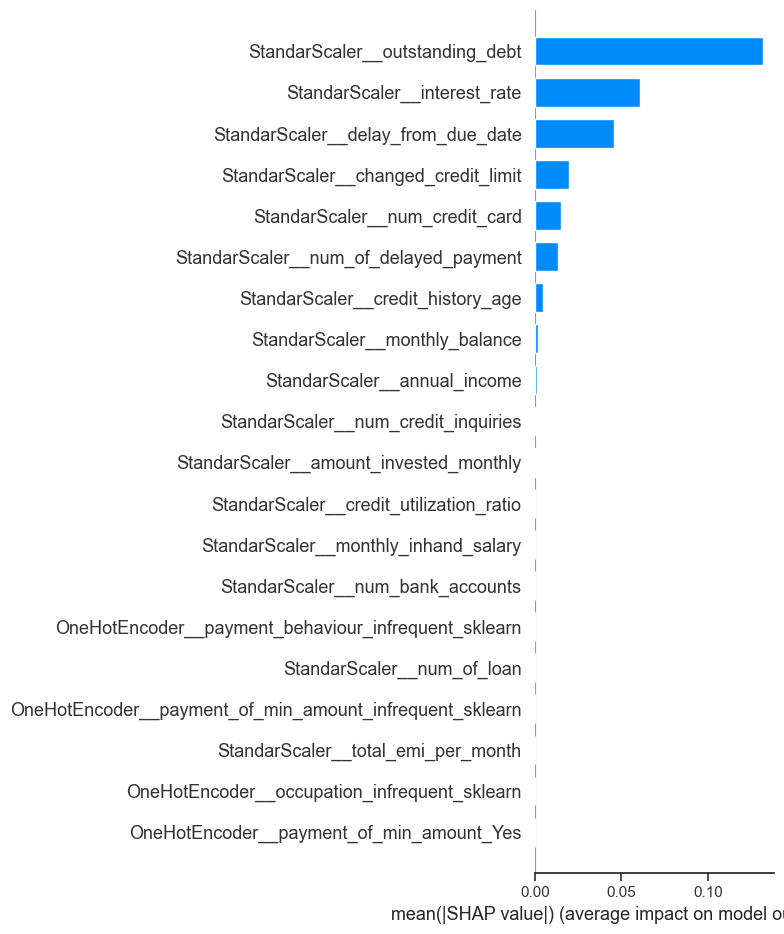

In [41]:
shap.summary_plot(shap_values, new_df, plot_type="bar")

Se aprecia que la caracteristica que más aporta a la predicción del modelo es 'outstanding_debt'. LO anterior tiene sentido puesto que, la deuda que presentan los clientes es un muy buen indicio de si son clientes riesgosos o seguros. Por otro lado, las caracteristicas 'interest rate' y 'delay_from_due_date', que representan el interes de la tarjeta de credito y el numero de dias promedios que los clientes tardan en pagar su deuda, respectivamente, tambien son variables importantes para predecir el riesgo de un cliente. Las demás variables aportan de forma bastante baja a las predicciones del modelo.

Por otro lado existen caracteristicas irrelevantes para el dataset tales como "annual_income" que representa los ingresos anuales del cliente, "montly_balance" que representa el balance mensual y entre otras. Estas varaibles a priori podrian parecer relevantes para identificar el riesgo de dar creditos a un cliente, pero gracias al metodo SHAP es posible descubrir lo irrelevante de estas caracteristicas a la hora de predecir el comportamiento el cliente.

A continuación se presentaran 10 observaciones aleatorias para verificar la coherencias de las caracteristicas.

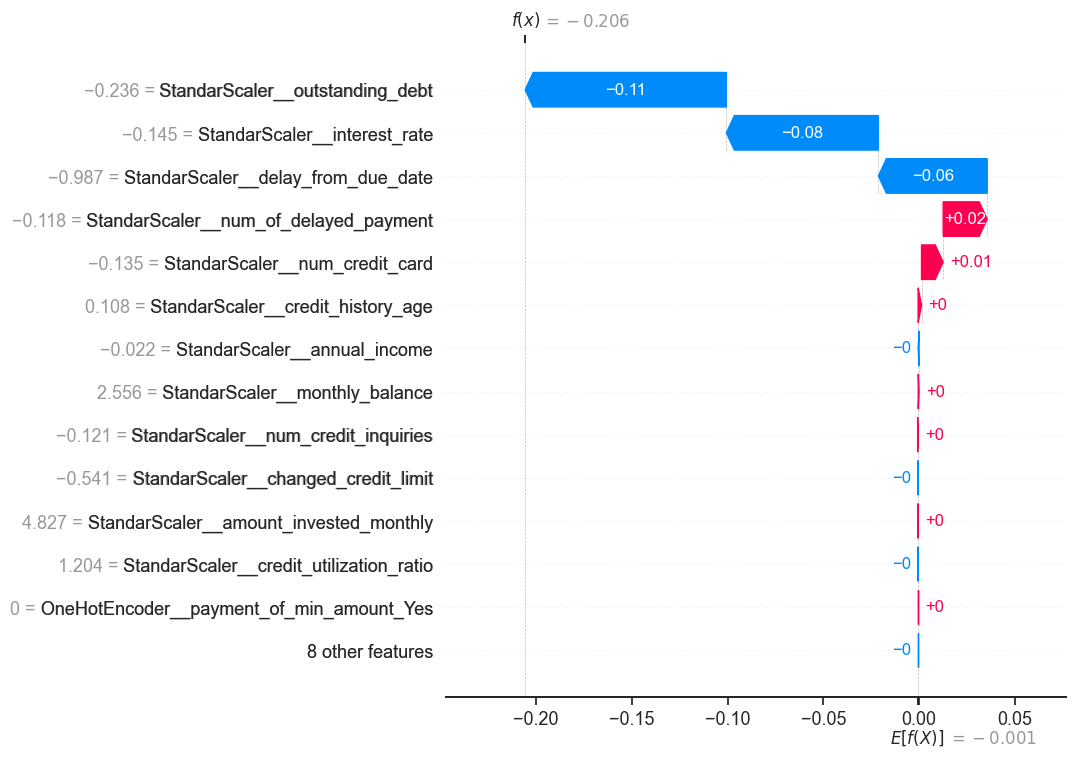

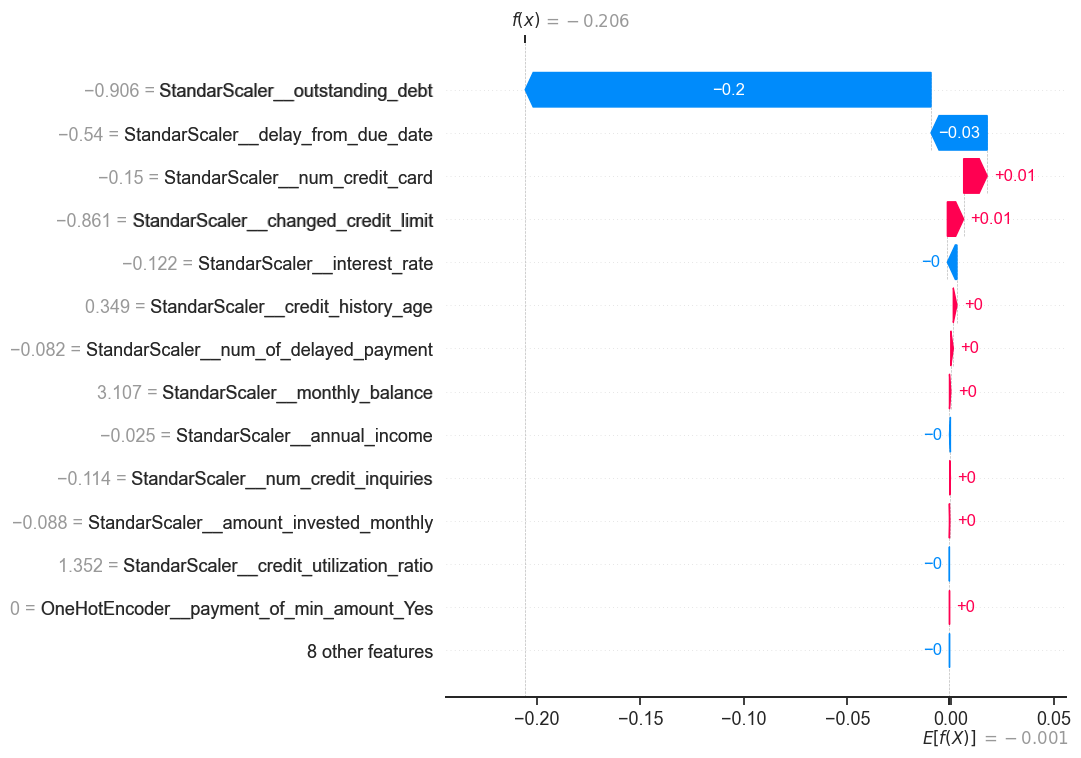

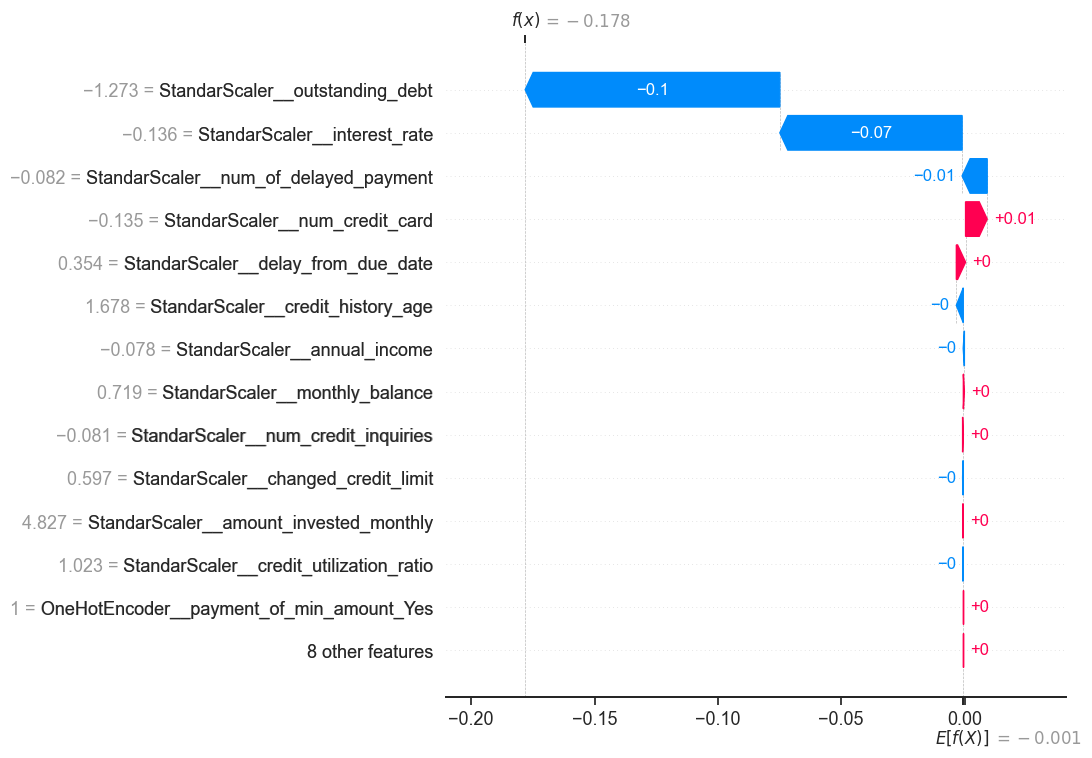

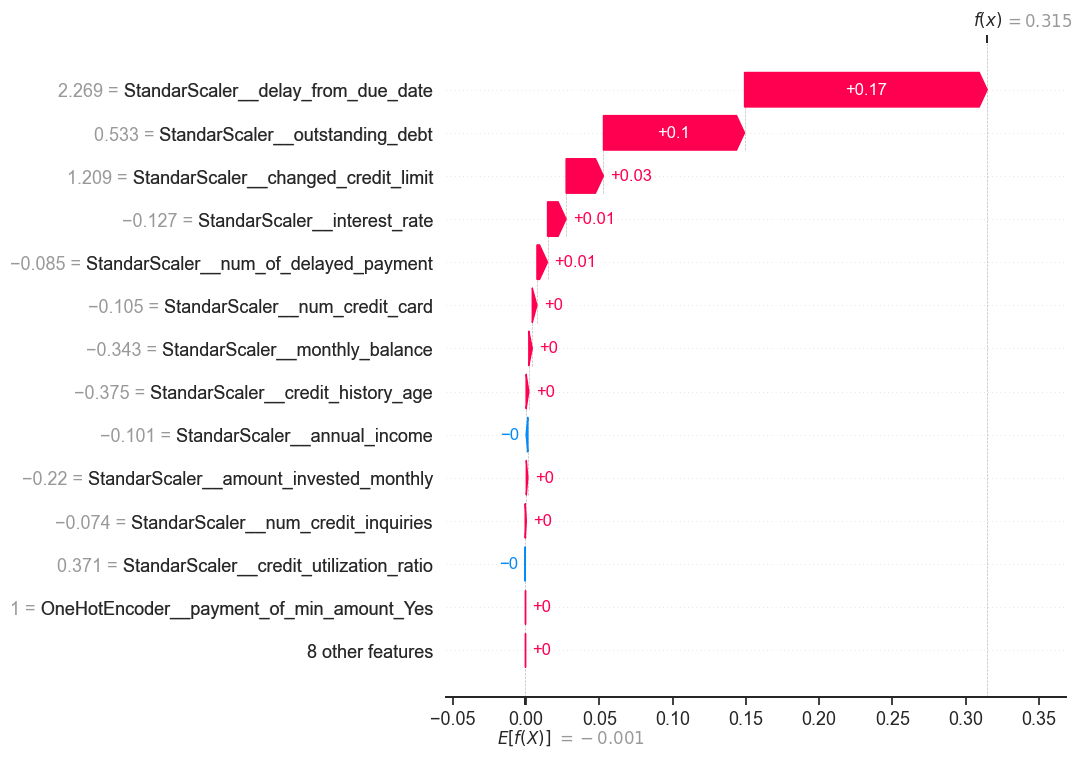

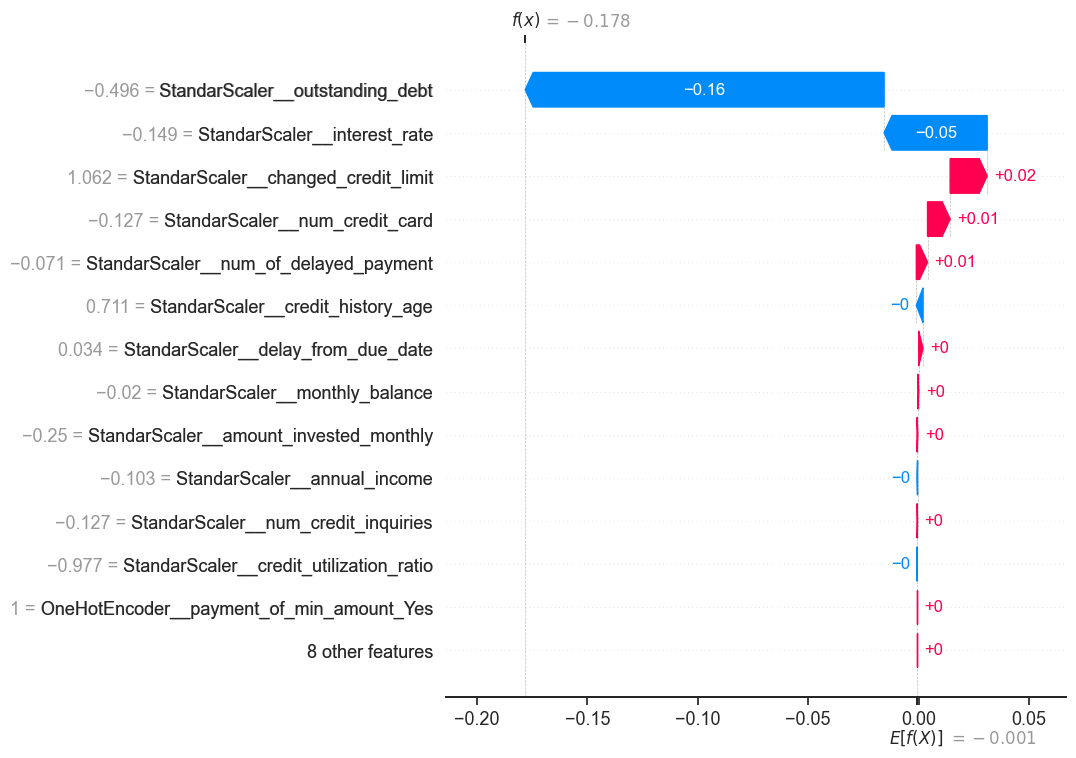

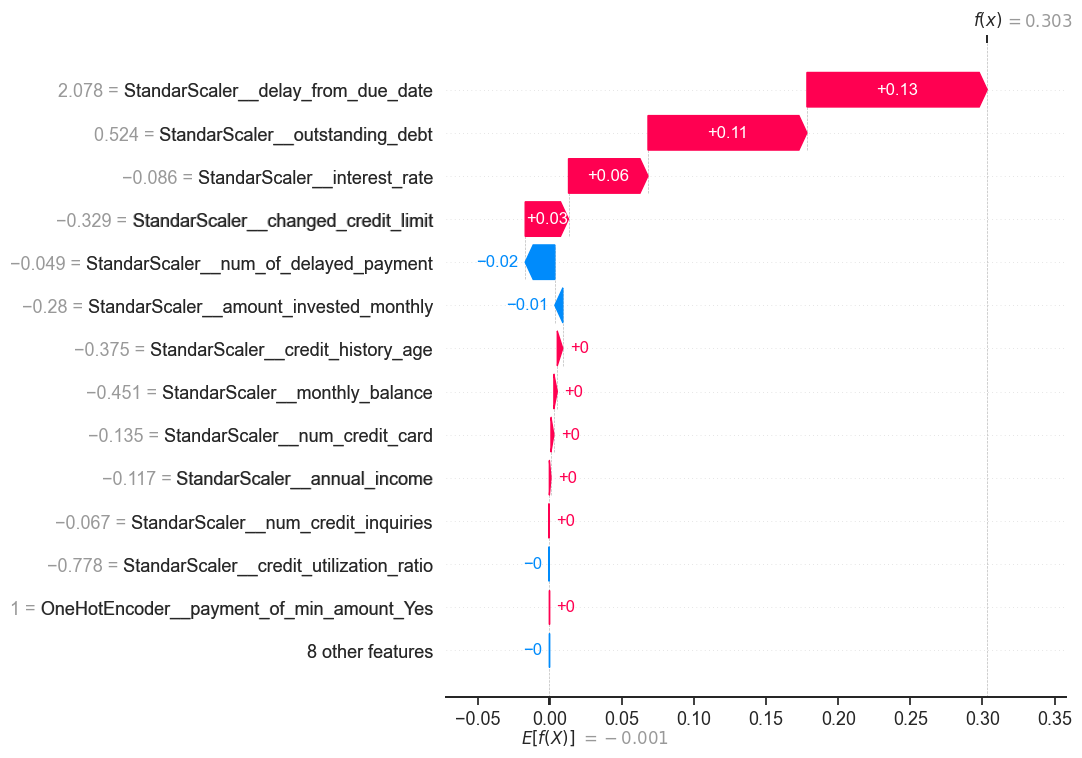

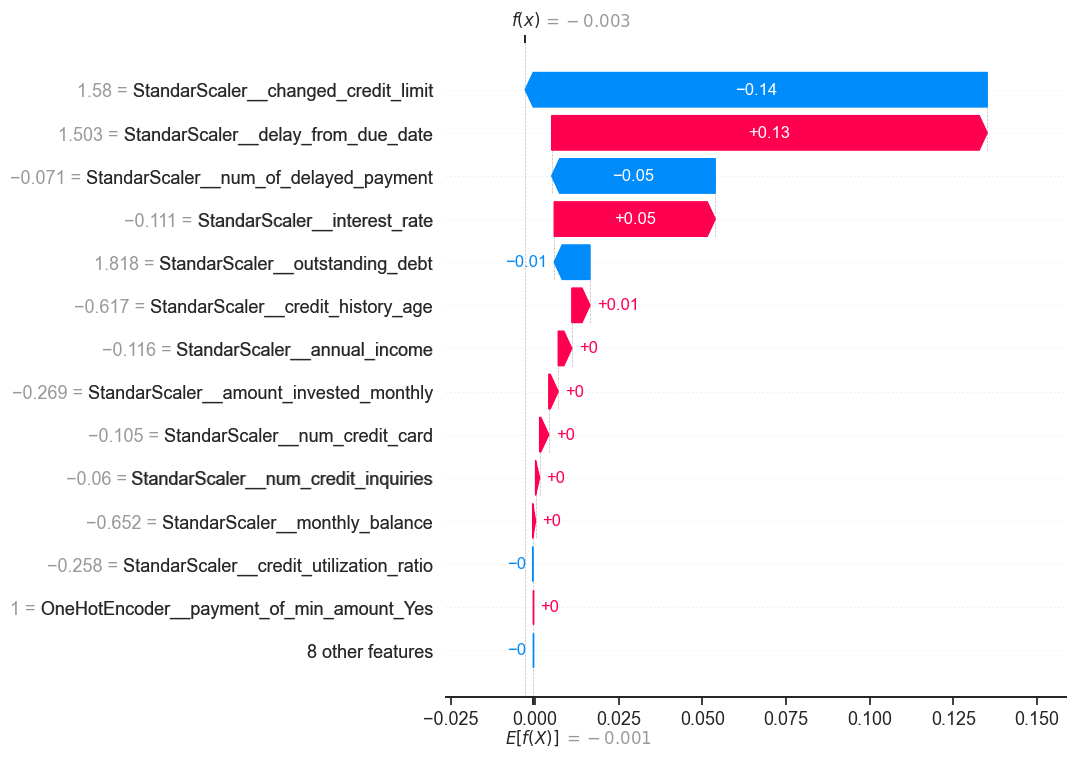

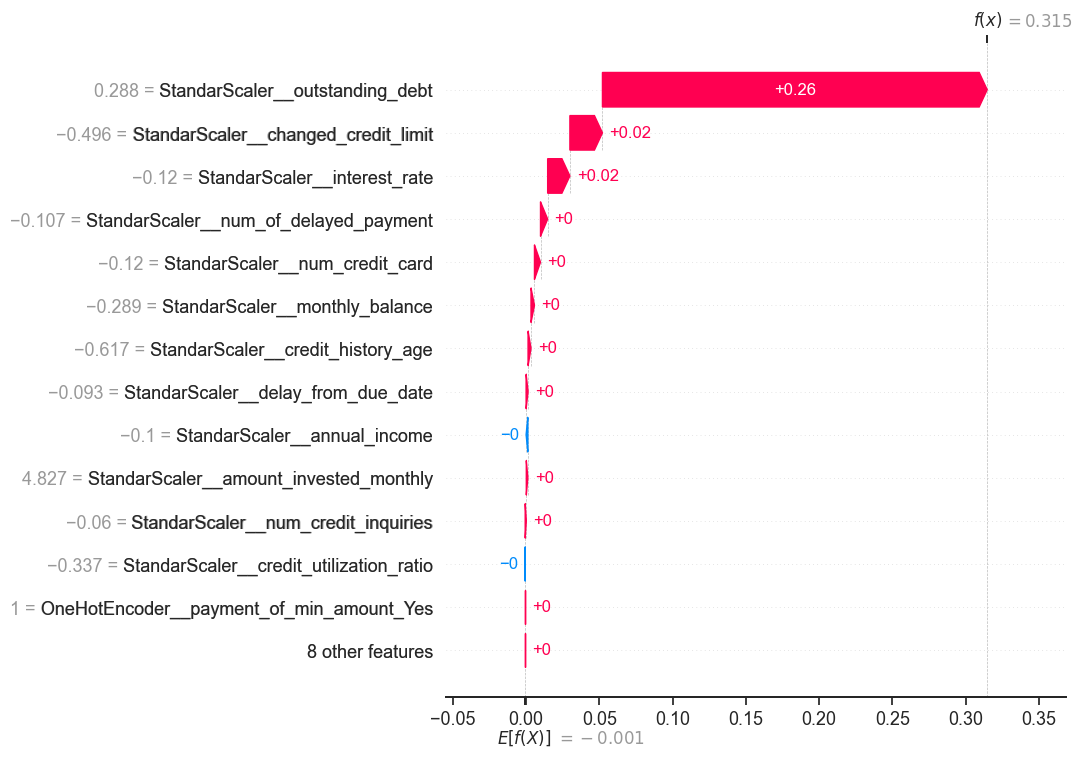

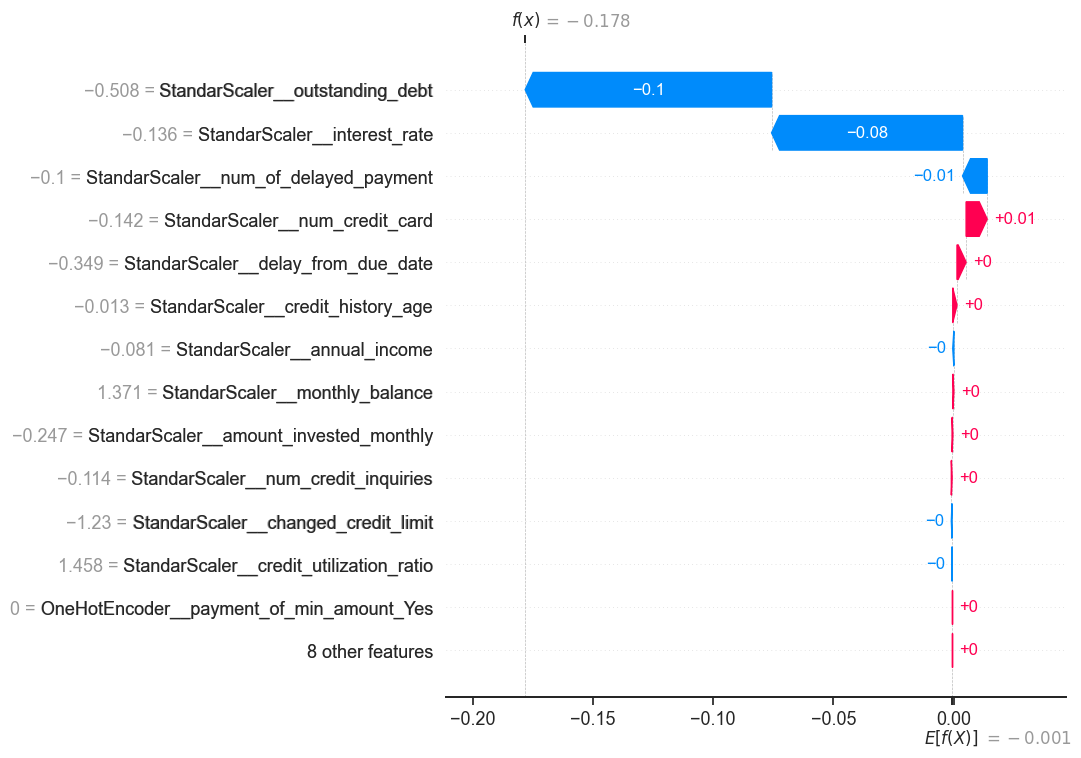

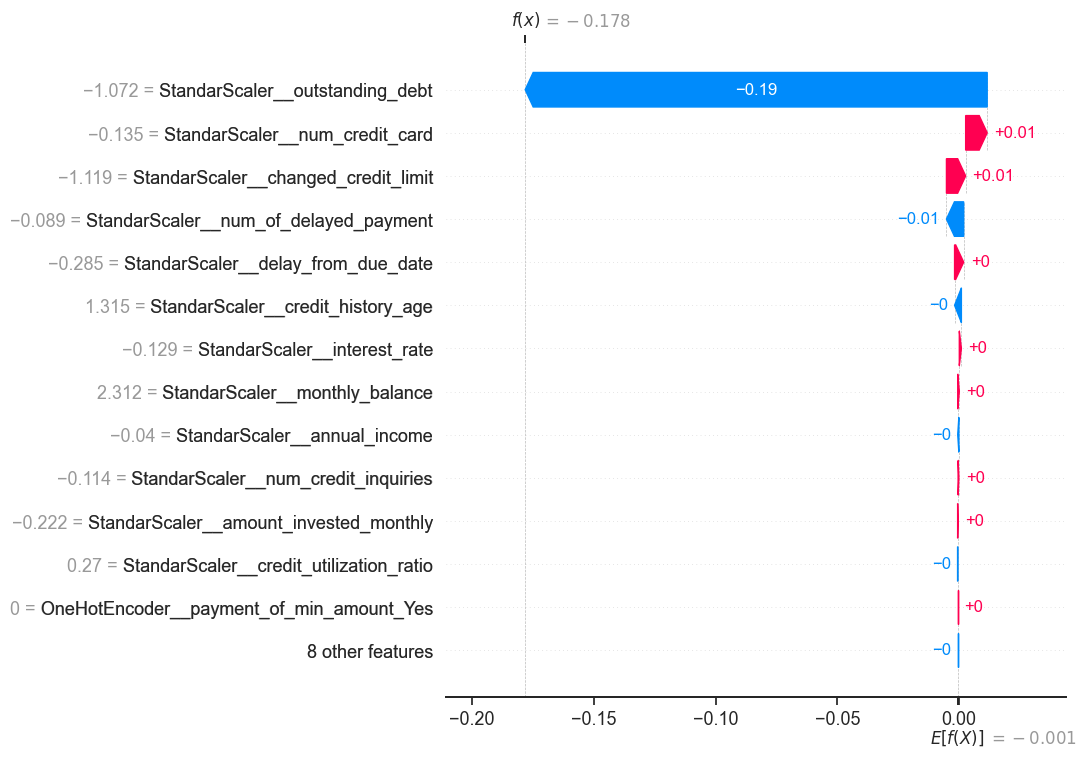

In [43]:
for idx in [1, 37, 54,103, 1024, 2000, 3450, 4111, 5900, 6333  ]:
    
    shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)

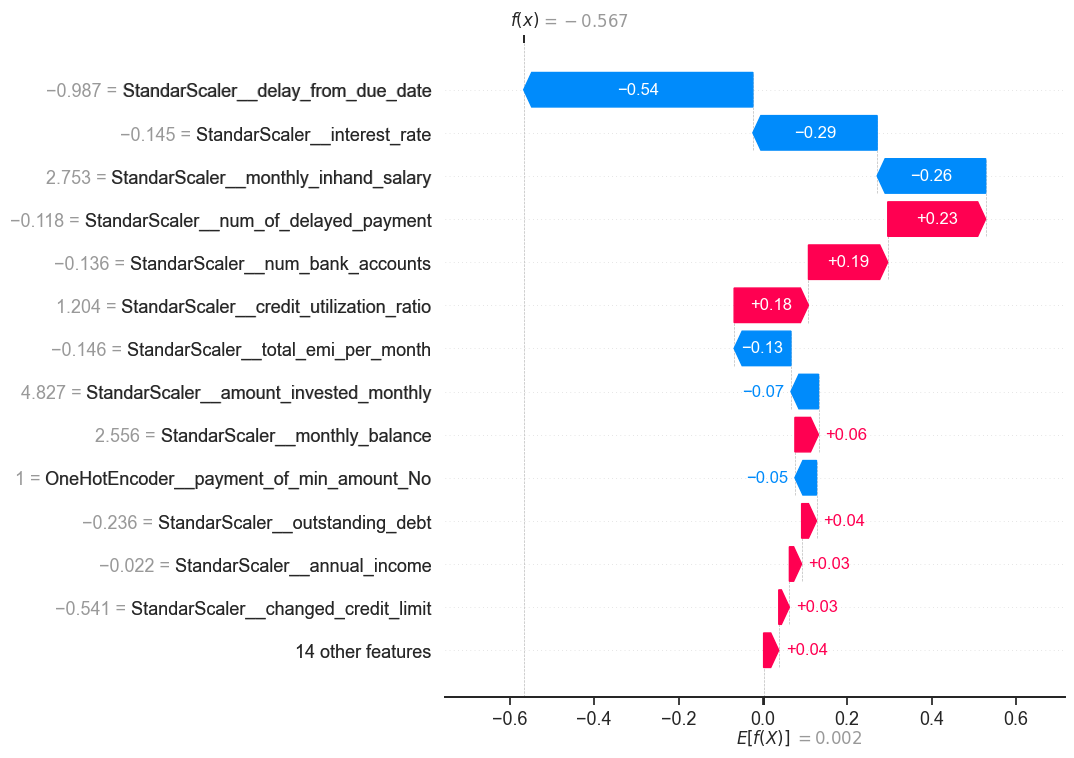

In [28]:
idx=1
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)

En la mayoria de las observaciones se aprecia que las caracteristicas más determinantes son "outstanding_debt", "interest_rate" y "delay_from_due_rate", por lo cual se puede apreciar una coherencia de las variables a lo largo de las observaciones realizadas. Además se aprecia la fuerte relación de estas tres variables para aportar en la prediccion del problema.

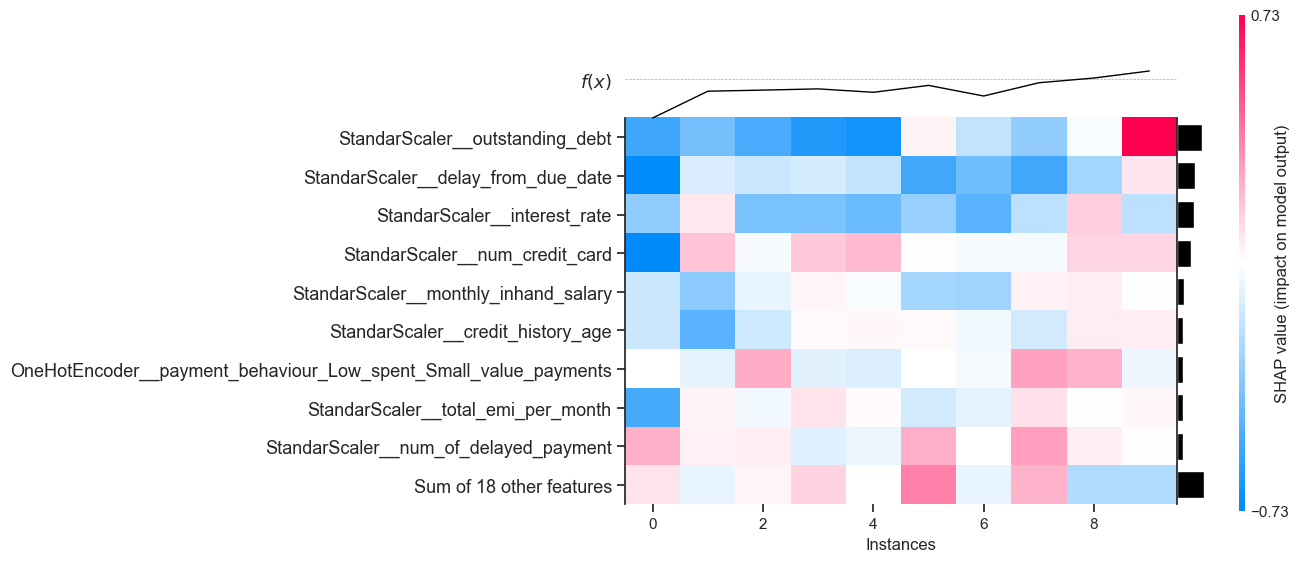

In [27]:
idx=2
shap.plots.heatmap(shap_values[:10])

In [32]:
# obtenemos los shap values
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)

# Obtenemos los nombres ordenados de mayor a menor
feature_importance_names = new_df.columns[shap_values_abs.argsort()[::-1]]

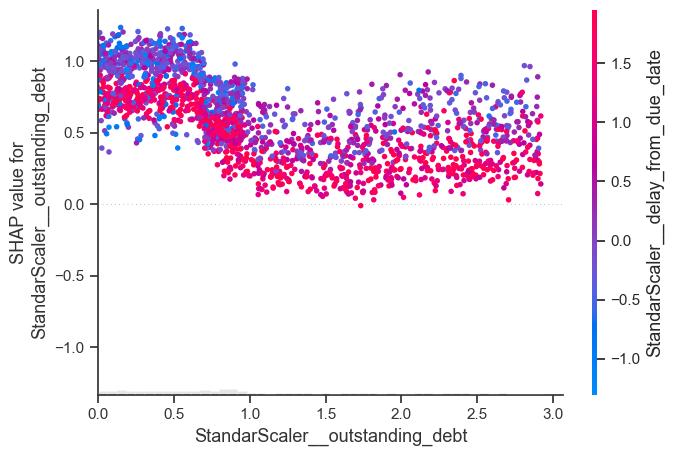

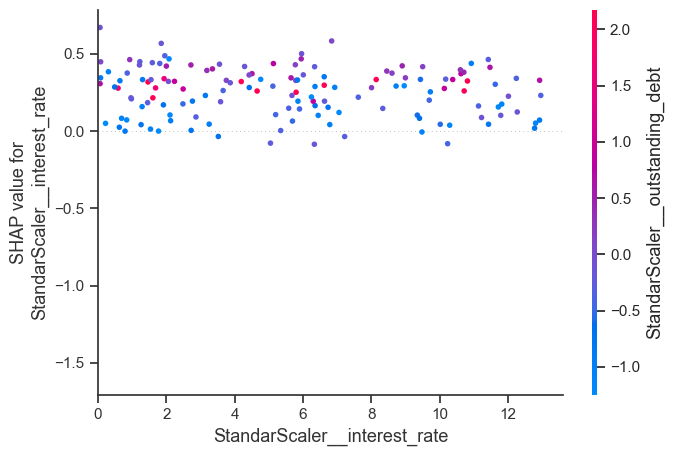

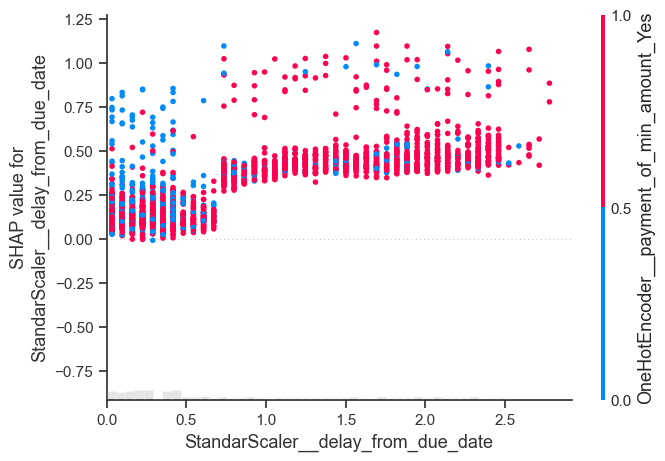

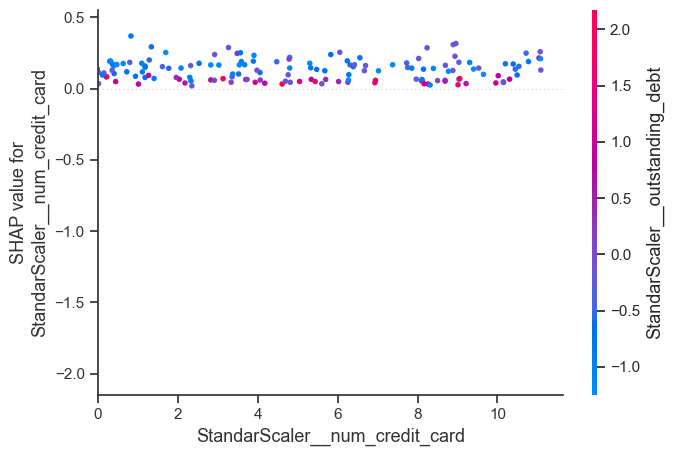

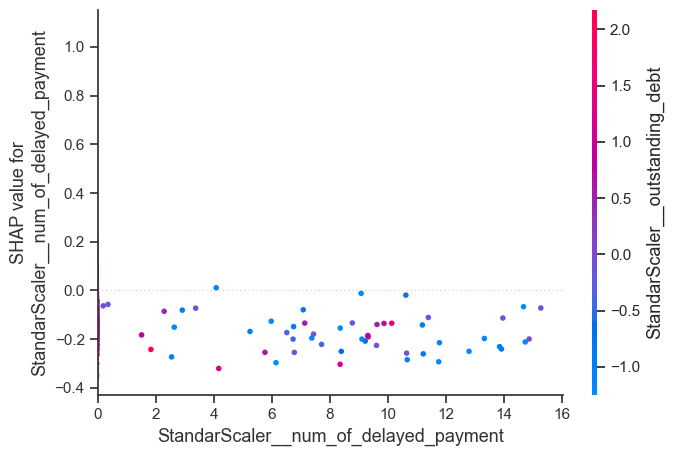

In [33]:
for name in feature_importance_names[:5]:
    #shap.dependence_plot(name, shap_values.values, X)
    shap.plots.scatter(shap_values[:,name], 
                       color=shap_values, xmin=0)   

## 7. Conclusiones

Luego de aplicar todos los modelos requeridos y de sus respectivas optimizaciones de parámetros, se obtuvo que el mejor clasificador fue 'XGBClassifier', con un f1_score del 60,84%, un resultado bastante bajo para la predicción. Por lo cual se resolvio medianamente bien el problema planteado, con bastantes mejorar por aplicar. Por otro lado, gracias al EDA realizado se pudieron observar valores extraños en el dataset estudiado, asi como tambien se observó que las clases estaban bastante desbalanceadas. Lo anterior permitió eliminar valores no deseados del dataset, asi como tambien balancear correctamente las clases, todo con el objetivo de poder obtener una mejor predicción del modelo. 

Respecto al rendimiento del baseline y de la optimización de parametros, no se obtuvieron mejoras relevantes en esta última, obteniendo un f1_score del 60,66% del modelo "XGBClassifier" en el baseline y un f1_score de 60,84% en la optimización, logrando una mejora bastante baja.

Por otra parte, en la interpretabilidad del modelo, en la cual se utilizó el metodo SHAP, se descubrio que las caracteristicas más relevantes para predecir el riesgo de un cliente son: "outstanding_debt", "interest_rate" y "delay_from_due_rate". Estas variables estan relacionadas con el pago de deudas que poseen los clientes, por lo cual es bastante logico qure sean determinantes a la hora de predecir el tipo de cliente.

En resumen, se obtuvieron bajos resultados en las predicciones del modelo elegido. Es posible que aplicando metodos como "Prunning" en la optimización de parametros, el modelo mejore en su predicción. Por otra parte, aplicar metodos de reducción de caracteristicas como PCA, es probable que aumente el f1_score dada la gran cantidad de columnas irrelevantes tal como se vio en la interpretabilidad del modelo. 

Finalmente, respecto a los aprendizajes obtenidos en este proyecto, se comprendio de mejor manera la utilización de Optuna y el metodo SHAP. Por otro lado, como aprendizaje pendiente quedo la mejora en la forma de optimizar los parametros, puesto que se requirieron mejores metodos en el modelo utilizado.



